In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf

In [65]:
data = pd.read_csv("RNW.TO.csv", date_parser = True)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-08-09,10.00,10.00,9.95,9.98,5.959726,2179000
1,2013-08-12,10.00,10.00,9.95,9.96,5.947781,300000
2,2013-08-13,9.97,9.97,9.93,9.93,5.929870,270700
3,2013-08-14,9.95,10.00,9.88,9.99,5.965699,365200
4,2013-08-15,9.99,10.00,9.97,10.00,5.971668,56200
...,...,...,...,...,...,...,...
1694,2020-05-11,14.99,15.12,14.81,15.12,15.037871,540700
1695,2020-05-12,15.15,15.50,14.97,15.08,14.998089,785300
1696,2020-05-13,14.86,15.06,14.30,14.36,14.282000,867800
1697,2020-05-14,14.15,14.28,13.59,14.20,14.200000,653500


In [5]:
data_training = data[data['Date']<'2020-01-01'].copy()
data_testing = data[data['Date']>='2020-01-01'].copy()

In [25]:
training_data = data_training.drop(['Date','Adj Close'], axis =1)
training_data #Going to be predicting the open price of the 61st day

,Open,High,Low,Close,Volume
0,10.00,10.00,9.95,9.98,2179000
1,10.00,10.00,9.95,9.96,300000
2,9.97,9.97,9.93,9.93,270700
3,9.95,10.00,9.88,9.99,365200
4,9.99,10.00,9.97,10.00,56200
...,...,...,...,...,...
1599,15.58,15.70,15.54,15.66,440600
1600,15.66,15.68,15.54,15.62,82800
1601,15.62,15.73,15.62,15.70,269600
1602,15.70,15.71,15.53,15.63,194800


In [21]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)

In [22]:
X_train = []
y_train = []

In [23]:
for i in range (60, training_data.shape[0]):
    X_train.append(training_data[i-60:i]) #0 to 60
    y_train.append(training_data[i, 0]) #predict Open price for 60th data

In [33]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((1544, 60, 5), (1544,))

In [34]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [41]:
regressor = Sequential()
regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1],5)))
regressor.add(Dropout(0.2))#20% of neurons will be randomly dropped

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3)) #20% of neurons will be randomly dropped

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4)) #30% of neurons will be randomly dropped

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5)) #40% of neurons will be randomly dropped

regressor.add(Dense(units = 1))


In [42]:
regressor.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60, 50)            11200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 60, 80)            45120     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 80)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 120)              

In [43]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
49/49 [==============================] - 8s 162ms/step - loss: 0.0737
Epoch 2/30
49/49 [==============================] - 7s 134ms/step - loss: 0.0176
Epoch 3/30
49/49 [==============================] - 6s 128ms/step - loss: 0.0135
Epoch 4/30
49/49 [==============================] - 7s 140ms/step - loss: 0.0119
Epoch 5/30
49/49 [==============================] - 8s 158ms/step - loss: 0.0112
Epoch 6/30
49/49 [==============================] - 9s 192ms/step - loss: 0.0107
Epoch 7/30
49/49 [==============================] - 7s 150ms/step - loss: 0.0094
Epoch 8/30
49/49 [==============================] - 8s 164ms/step - loss: 0.0098
Epoch 9/30
49/49 [==============================] - 9s 180ms/step - loss: 0.0091
Epoch 10/30
49/49 [==============================] - 8s 162ms/step - loss: 0.0084
Epoch 11/30
49/49 [==============================] - 6s 132ms/step - loss: 0.0091
Epoch 12/30
49/49 [==============================] - 8s 155ms/step - loss: 0.0075
Epoch 13/30
49/49 [======

In [45]:
past_60_days = data_training.tail (60)
df = past_60_days.append(data_testing, ignore_index = True)
df = df.drop([ 'Date','Adj Close'], axis = 1)

In [47]:
inputs = scaler.fit_transform(df)
inputs.shape

(155, 5)

In [49]:
X_test = []
y_test = []
for i in range (60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

In [50]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((95, 60, 5), (95,))

In [57]:
prediction = regressor.predict(X_test)
test_error_rate = regressor.evaluate(X_test, y_test)
test_error_rate

3/3 [==============================] - 0s 26ms/step - loss: 11.6886


11.688583374023438

In [52]:
scaler.scale_

array([1.56250000e-01, 1.67504188e-01, 1.37551582e-01, 1.38888889e-01,
       2.99159362e-07])

In [53]:
prediction = prediction/1.56250000e-01
y_test = y_test/1.56250000e-01


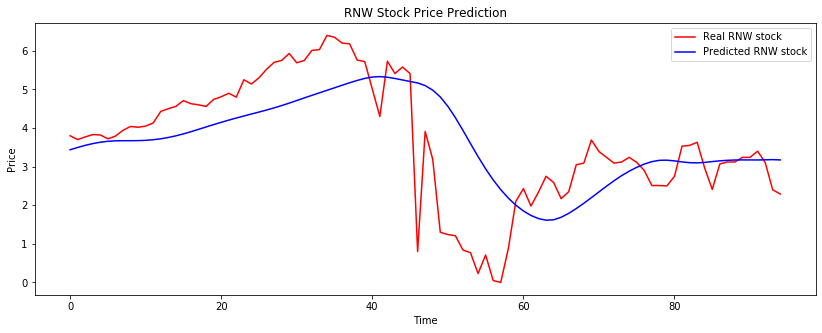

In [54]:
# Visualize Results

plt.figure(figsize = (14,5))
plt.plot(y_test, color = 'red', label = 'Real RNW stock')
plt.plot(prediction, color = 'blue', label = 'Predicted RNW stock')
plt.title('RNW Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()